In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import empyrical as empy
import matplotlib.pyplot as plt
import seaborn as sns;
# sns.set_theme(color_codes=True)
from sklearn.metrics import accuracy_score, precision_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
start_date = datetime.date(2008, 1, 31)

In [3]:
def parse_date(df, start_date, end_date):
    if start_date is not None:
        df = df[df.index >= start_date]
    if end_date is not None:
        df = df[df.index <= end_date]
    return df

In [4]:
def fin_metircs(ret):
    cum_returns = empy.cum_returns(ret)
    res = pd.Series()
    res['total return'] = cum_returns[-1]
    res['annual return'] = empy.annual_return(ret)
    res['volatility'] = empy.annual_volatility(ret)
    res['SHARPE RATIO'] = empy.sharpe_ratio(ret)
    res['Max-DD'] = empy.max_drawdown(ret)
    return cum_returns, res

def get_label(dfclose, pp=21):
    dfclose.index = pd.to_datetime(dfclose.index, format='%Y-%m-%d').date
    y_pctch = -dfclose.pct_change(-pp).dropna(how='all')
    y_label = (y_pctch > 0).astype(int)
    return y_label

In [5]:
def rb_return(ret, preds, freq='D'):
    ret = parse_date(ret, preds.index[0], preds.index[-1])
    if freq == 'D':
        tmp = pd.concat([ret, preds], axis=1).fillna(method='ffill')
        case_ret = tmp.iloc[:, 0] * tmp.iloc[:, 1]
        period_results = preds
    elif freq == 'M':
        preds = preds.to_frame()
        preds.index = pd.to_datetime(preds.index)
        preds = preds.sort_index()
        preds['date'] = preds.index
        period_index = preds.index.to_period('M')
        period_results = preds.groupby(period_index).nth(0)
        
        period_results = period_results.set_index('date', drop=True)
        period_results.index = pd.to_datetime(period_results.index).date
        tmp = pd.concat([ret, period_results], axis=1)
        tmp = tmp.fillna(method='ffill')
        case_ret = tmp.iloc[:, 0] * tmp.iloc[:, 1]
    return case_ret, period_results

In [6]:
def calculate_metrics(preds, y, ret_pp_case, ret, start_date, end_date, freq='M'):
    preds = parse_date(preds, start_date, end_date)
    ret = parse_date(ret, start_date, end_date)
    print("preds: {} to {}".format(preds.index[0], preds.index[-1]))
    metrics = pd.DataFrame()
    cum_returns = pd.DataFrame()
    for case in preds.columns:
        sub_preds = preds[case]

        sub_preds_shift = sub_preds.shift(1).dropna()
        case_ret, period_preds = rb_return(ret, sub_preds_shift, freq)
        case_cum_returns, case_fin_res = fin_metircs(case_ret)
        
        tmp = pd.concat([period_preds, y], axis=1).dropna()
        sub_acc = pd.Series()
        sub_acc['accuracy'] = accuracy_score(tmp.iloc[:, 1], tmp.iloc[:, 0])
        sub_acc['precision'] = precision_score(tmp.iloc[:, 1], tmp.iloc[:, 0])
        tmp2 = pd.concat([period_preds, ret_pp_case], axis=1).dropna()
        sub_acc['MSE'] = mean_squared_error(
            y_true = tmp2.iloc[:, 1]/tmp2.iloc[:, 1].std()+0.5, y_pred=tmp.iloc[:, 0])

        sub_metrics = pd.concat([sub_acc, case_fin_res])
        sub_metrics.name = case
        metrics = pd.concat([metrics, sub_metrics], axis=1)
        case_cum_returns.name = case
        cum_returns = pd.concat([cum_returns, case_cum_returns], axis=1)
    return metrics, cum_returns

In [7]:
price = pd.read_csv('XAU_USD.csv', index_col=0)['adj_close']
price.index = pd.to_datetime(price.index).date
ret = price.pct_change(1).dropna()
ret_pp1 = -price.pct_change(-1).dropna()
ret_pp21 = -price.pct_change(-21).dropna()
ret_pp10 = -price.pct_change(-10).dropna()
ret_pp5 = -price.pct_change(-5).dropna()
ret_pp = pd.concat([ret_pp1, ret_pp21, ret_pp10, ret_pp5], axis=1)
ret_pp.columns = ['pp1', 'pp21', 'pp10', 'pp5']
ret_pp = ret_pp.dropna()

In [8]:
y_pp21 = get_label(price, 21)
y_pp10 = get_label(price, 10)
y_pp5 = get_label(price, 5)
yy = pd.concat([y_pp21, y_pp10, y_pp5], axis=1)
yy.columns = ['pp21', 'pp10', 'pp5']
yy = yy.dropna()

## ML as pipeline

In [9]:
def get_preds(file):
    df = pd.read_csv(file, index_col=0, header=1)
    df.index = pd.to_datetime(df.index).date
    return df

In [10]:
def cases_analysis(case, yy, ret_pp, ret, freq):
    folder = os.path.join('ML-result', case)
    ensemble_preds = pd.DataFrame()
    for fn in os.listdir(folder):
        fpath = os.path.join(folder, fn, 'XAUUSD_preds.csv')
        try:
            ser = get_preds(fpath)['Simple Voting']
            ser.name = fn
            ensemble_preds = pd.concat([ensemble_preds, ser], axis=1)
        except:
            pass

    # ensemble_metrics
    ensemble_preds = ensemble_preds.dropna()
#     start_date = ensemble_preds.index[0]
    end_date = ensemble_preds.index[-1]
    buy_and_hold = pd.Series(1, index=ensemble_preds.index)
    buy_and_hold.name = 'buy_and_hold'
#     real = yy[case]
#     real.name = 'REAL'
    ensemble_preds = pd.concat([buy_and_hold, ensemble_preds], axis=1)
    ensemble_preds = ensemble_preds.dropna()

    metrics, cum_returns = calculate_metrics(ensemble_preds, yy[case], ret_pp['pp1'], ret, start_date, end_date, freq)
    metrics = metrics.sort_values('SHARPE RATIO', axis=1, ascending=False)
    
#     ret = parse_date(ret, start_date, end_date)
#     base_cum_returns, base_metrices = fin_metircs(ret)
#     base_cum_returns.name = 'REAL'
#     base_metrices.name = 'REAL'
    
#     cum_returns = pd.concat([base_cum_returns, cum_returns], axis=1)
#     metrics = pd.concat([base_metrices, metrics], axis=1)
    return metrics, cum_returns

In [11]:
freq = 'M'
all_metrics = pd.DataFrame()

## PP21

In [12]:
pp = 'pp21'
metrics, cum_returns = cases_analysis(pp, yy, ret_pp, ret, freq)
all_metrics = pd.concat([all_metrics, metrics], axis=1)
metrics

preds: 2008-01-31 to 2021-12-30


,buy_and_hold,Top3AllLow2,VoteAll_sk,Top3NNLow2,VoteAll_nlp,VoteAll_nn,Top5,Top5AllLow1,Top5NNLow1
accuracy,0.514970,0.526946,0.508982,0.514970,0.497006,0.497006,0.491018,0.502994,0.485030
precision,0.514970,0.529915,0.512658,0.521739,0.511628,0.508929,0.504505,0.512821,0.500000
MSE,1.187334,1.262783,1.161483,1.246344,1.304087,1.303876,1.315988,1.322856,1.278317
total return,0.960859,0.782776,0.528838,0.447970,0.398846,0.314699,0.309425,0.285688,0.230960
annual return,0.047925,0.041012,0.029950,0.026067,0.023608,0.019203,0.018918,0.017623,0.014550
volatility,0.172224,0.149818,0.167470,0.147915,0.143315,0.145285,0.150210,0.152443,0.146111
SHARPE RATIO,0.358028,0.343273,0.260069,0.248009,0.234557,0.203578,0.200068,0.191015,0.171991
Max-DD,-0.446595,-0.330062,-0.497792,-0.368189,-0.401893,-0.329396,-0.384936,-0.390526,-0.377674


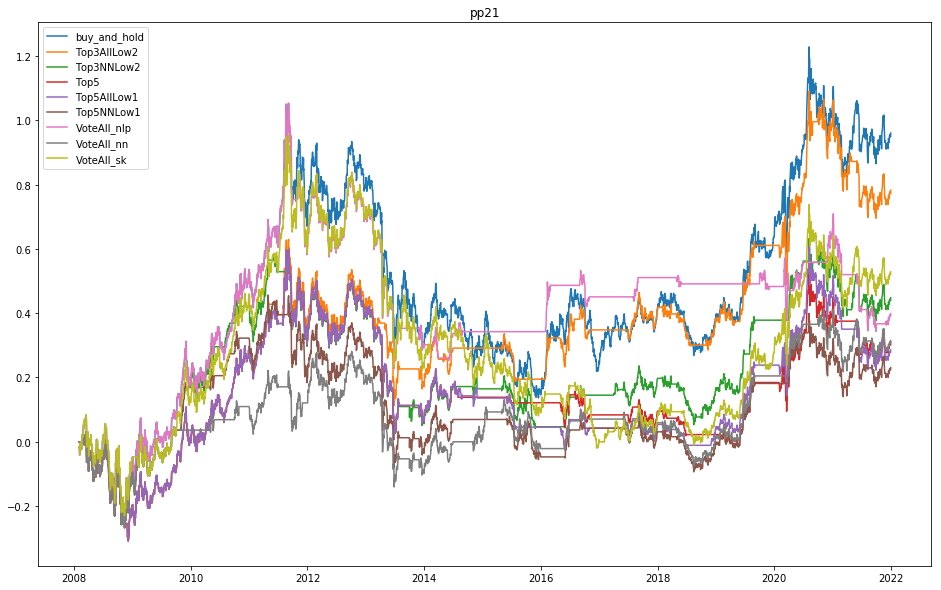

In [13]:
cum_returns.plot(title=pp, figsize=(16, 10))

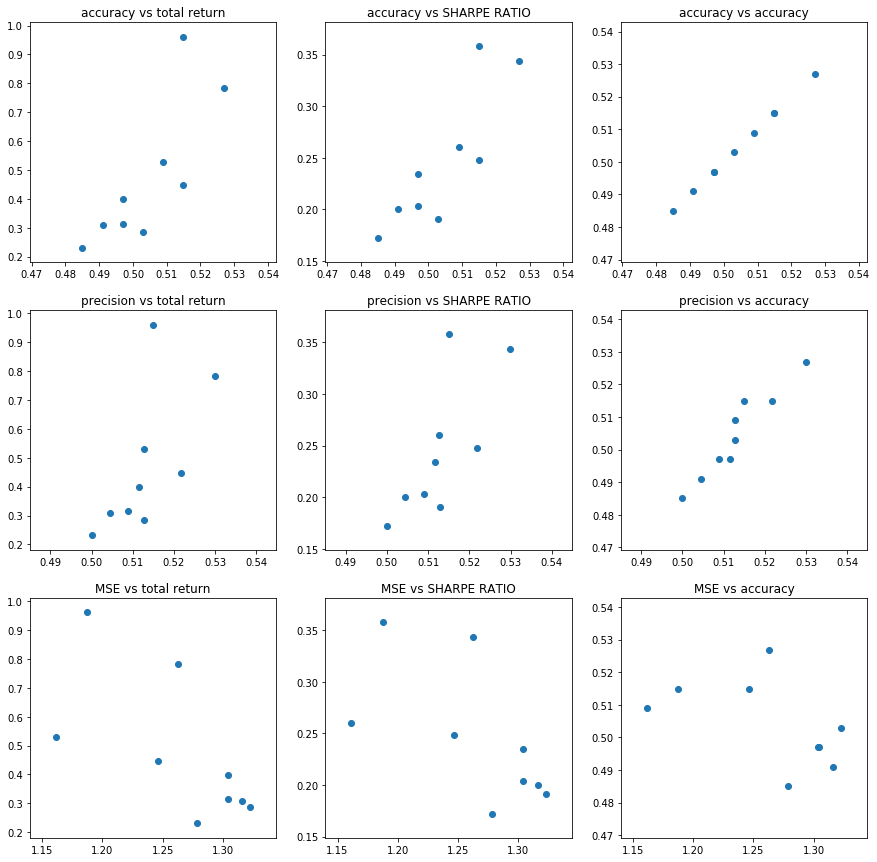

In [14]:
f, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(15,15))

for aidx, a in enumerate(['accuracy', 'precision', 'MSE']):
    for bidx, b in enumerate(['total return', 'SHARPE RATIO', 'accuracy']):
        axes[aidx][bidx].scatter(metrics.loc[a, :], metrics.loc[b, :])
        axes[aidx][bidx].set_title("{} vs {}".format(a, b))

## PP10

In [15]:
pp = 'pp10'
metrics, cum_returns = cases_analysis(pp, yy, ret_pp, ret, freq)
all_metrics = pd.concat([all_metrics, metrics], axis=1)
metrics

preds: 2008-01-31 to 2021-12-30


,Top5NNLow1PP10,Top10PP10,buy_and_hold,VoteAllSKPP10,Top3NNLow2PP10,Top5PP10,VoteAllNLPPP10,VoteAllNNPP10,Top5AllLow1PP10,Top3AllLow2PP10
accuracy,0.586826,0.526946,0.544910,0.562874,0.580838,0.532934,0.485030,0.544910,0.532934,0.497006
precision,0.587302,0.539474,0.544910,0.555556,0.581395,0.550388,0.519084,0.564103,0.546763,0.524823
MSE,1.249456,1.194241,1.187334,1.193616,1.227270,1.259145,1.211826,1.399180,1.306995,1.295249
total return,1.164201,1.143605,0.960859,0.924963,0.649229,0.563658,0.437481,0.362650,0.368556,0.326872
annual return,0.055137,0.054436,0.047925,0.046580,0.035392,0.031564,0.025548,0.021744,0.022051,0.019856
volatility,0.154006,0.166755,0.172224,0.168044,0.157446,0.155627,0.160179,0.145127,0.158624,0.158765
SHARPE RATIO,0.425551,0.401365,0.358028,0.354945,0.299690,0.277570,0.237640,0.220813,0.216986,0.203391
Max-DD,-0.342311,-0.356208,-0.446595,-0.405826,-0.376905,-0.345683,-0.480841,-0.408750,-0.490747,-0.497217


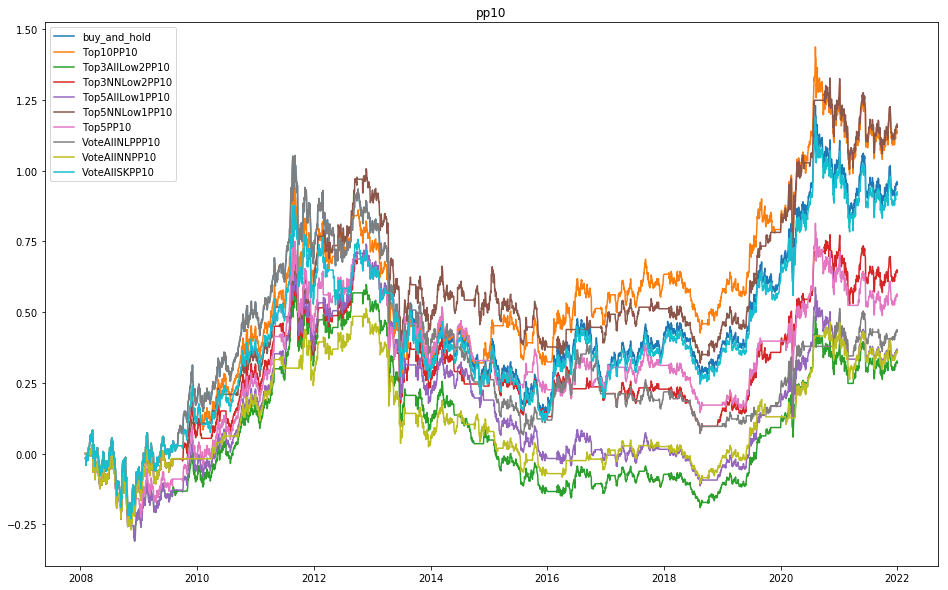

In [16]:
cum_returns.plot(title=pp, figsize=(16, 10))

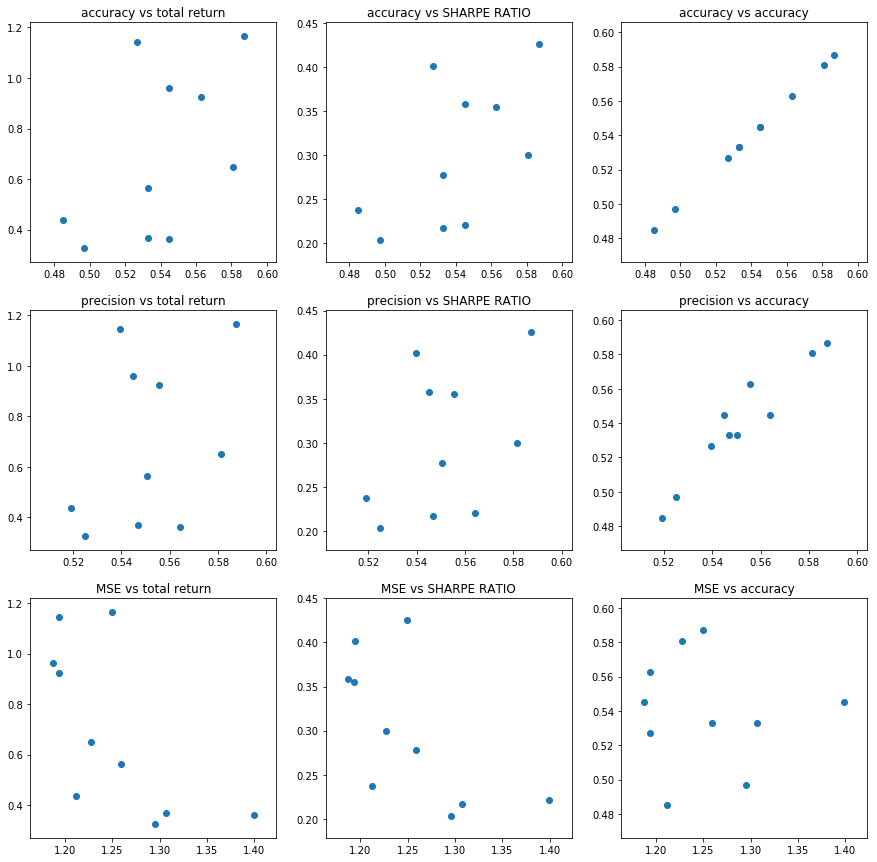

In [17]:
f, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(15,15))

for aidx, a in enumerate(['accuracy', 'precision', 'MSE']):
    for bidx, b in enumerate(['total return', 'SHARPE RATIO', 'accuracy']):
        axes[aidx][bidx].scatter(metrics.loc[a, :], metrics.loc[b, :])
        axes[aidx][bidx].set_title("{} vs {}".format(a, b))

## PP5

In [18]:
pp = 'pp5'
metrics, cum_returns = cases_analysis(pp, yy, ret_pp, ret, freq)
all_metrics = pd.concat([all_metrics, metrics], axis=1)
metrics

preds: 2008-01-31 to 2021-12-30


,Top5PP5,Top5AllLow1PP5,buy_and_hold,VoteAllSKPP5,Top10PP5,Top5NNLow1PP5,VoteAllNLPPP5,Top3AllLow2PP5,Top3NNLow2PP5,VoteAllNNPP5
accuracy,0.526946,0.544910,0.532934,0.520958,0.526946,0.526946,0.520958,0.502994,0.502994,0.502994
precision,0.536232,0.546763,0.532934,0.527607,0.532895,0.538462,0.533835,0.523077,0.523077,0.524590
MSE,1.129148,1.132729,1.187334,1.189122,1.133193,1.183494,1.233722,1.181577,1.181577,1.189708
total return,1.454212,1.123891,0.960859,0.791879,0.694976,0.651829,0.672138,0.443177,0.443177,0.289792
annual return,0.064402,0.053759,0.047925,0.041380,0.037363,0.035505,0.036385,0.025830,0.025830,0.017848
volatility,0.157009,0.160363,0.172224,0.170673,0.165807,0.154621,0.163859,0.156440,0.156440,0.150928
SHARPE RATIO,0.476047,0.406839,0.358028,0.323008,0.304252,0.303047,0.300132,0.241338,0.241338,0.192761
Max-DD,-0.446451,-0.424307,-0.446595,-0.472264,-0.481215,-0.486857,-0.399523,-0.473302,-0.473302,-0.532686


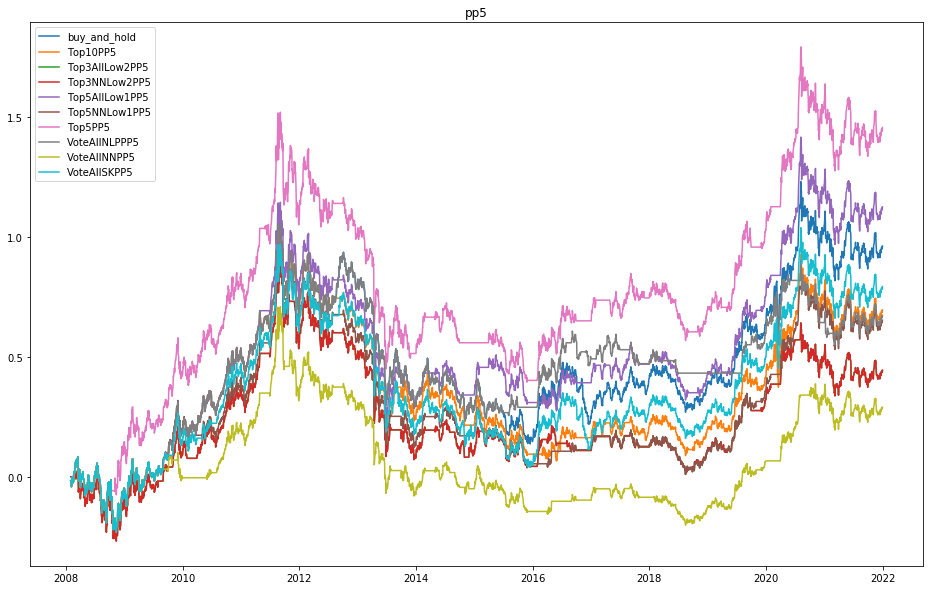

In [19]:
cum_returns.plot(title=pp, figsize=(16, 10))

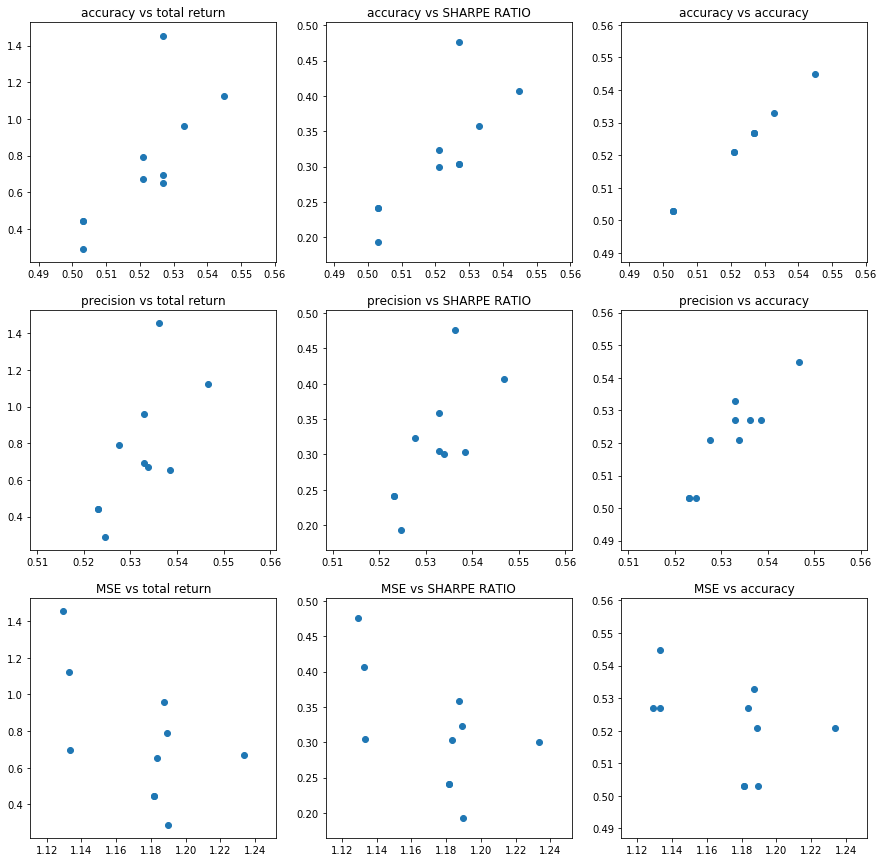

In [20]:
f, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(15,15))

for aidx, a in enumerate(['accuracy', 'precision', 'MSE']):
    for bidx, b in enumerate(['total return', 'SHARPE RATIO', 'accuracy']):
        axes[aidx][bidx].scatter(metrics.loc[a, :], metrics.loc[b, :])
        axes[aidx][bidx].set_title("{} vs {}".format(a, b))

## ALL cases

In [21]:
all_metrics.to_csv("./all_metrics_{}.csv".format(freq))

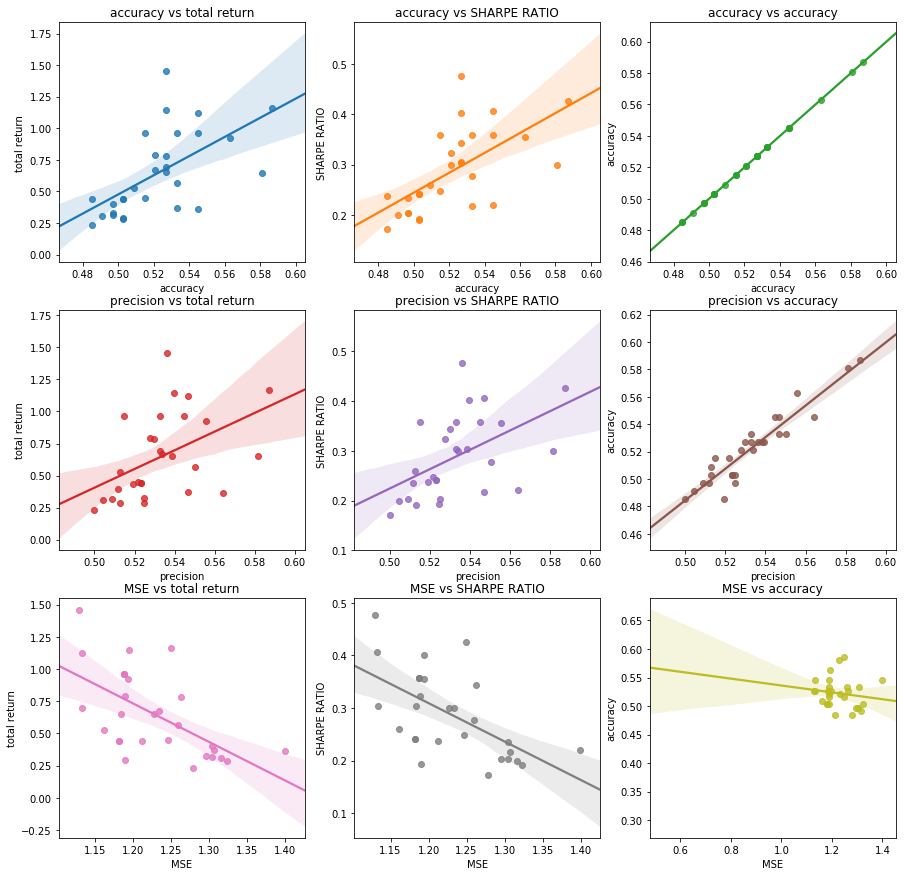

In [22]:
f, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(15,15))

for aidx, a in enumerate(['accuracy', 'precision', 'MSE']):
    for bidx, b in enumerate(['total return', 'SHARPE RATIO', 'accuracy']):
        sns.regplot(x=a, y=b, data=all_metrics.T, ax=axes[aidx][bidx])
#         scatter(all_metrics.loc[a, :], all_metrics.loc[b, :])
#         scaler = MinMaxScaler()
#         a_df = scaler.fit_transform(all_metrics.loc[a, :].values.reshape(-1, 1))
#         b_df = scaler.fit_transform(all_metrics.loc[b, :].values.reshape(-1, 1))
#         r2 = r2_score(a_df, b_df)
# #         r2 = r2_score(all_metrics.loc[a, :], all_metrics.loc[b, :])
#         r2 = np.round(r2, 3)
#         axes[aidx][bidx].set_title("{} vs {}, r^2: {}".format(a, b, r2))
        axes[aidx][bidx].set_title("{} vs {}".format(a, b))